In [1]:
import numpy as np
from collections import Counter

In [2]:
class Node:
    """
    Node class for Decision Tree
    """
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature      # Index of feature to split on
        self.threshold = threshold  # Threshold value for the split
        self.left = left            # Left subtree (samples where feature <= threshold)
        self.right = right          # Right subtree (samples where feature > threshold)
        self.value = value          # Predicted class (only for leaf nodes)
    
    def is_leaf(self):
        return self.value is not None


In [3]:
class DecisionTree:
    """
    Decision Tree Classifier implementation from scratch
    """
    def __init__(self, max_depth=100, min_samples_split=2, min_gain=0.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_gain = min_gain
        self.root = None
    
    def fit(self, X, y):
        """
        Build the decision tree
        
        Parameters:
        -----------
        X : np.ndarray
            Training features of shape (n_samples, n_features)
        y : np.ndarray
            Target values of shape (n_samples,)
        """
        self.n_features = X.shape[1]
        self.root = self._grow_tree(X, y)
    
    def _grow_tree(self, X, y, depth=0):
        """
        Recursively build the decision tree
        
        Parameters:
        -----------
        X : np.ndarray
            Training features
        y : np.ndarray
            Target values
        depth : int
            Current depth of the tree
            
        Returns:
        --------
        Node
            Root node of the tree/subtree
        """
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Check stopping criteria
        if (depth >= self.max_depth or 
            n_samples < self.min_samples_split or 
            n_classes == 1):
            # Create a leaf node
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        # Find the best split
        best_feature, best_threshold = self._best_split(X, y)
        
        # If no improvement, create a leaf node
        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        # Split the data
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        
        # Recursively grow the left and right trees
        left_tree = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._grow_tree(X[right_indices], y[right_indices], depth + 1)
        
        return Node(feature=best_feature, threshold=best_threshold, 
                    left=left_tree, right=right_tree)
    
    def _best_split(self, X, y):
        """
        Find the best feature and threshold for splitting the data
        
        Parameters:
        -----------
        X : np.ndarray
            Training features
        y : np.ndarray
            Target values
            
        Returns:
        --------
        best_feature : int or None
            Index of the best feature to split on
        best_threshold : float or None
            Best threshold value for the split
        """
        best_gain = self.min_gain
        best_feature = None
        best_threshold = None
        
        current_impurity = self._gini_impurity(y)
        
        # Try all features
        for feature_idx in range(self.n_features):
            # Get unique values for the feature
            thresholds = np.unique(X[:, feature_idx])
            
            # Try all thresholds
            for threshold in thresholds:
                # Split the data
                left_indices = X[:, feature_idx] <= threshold
                right_indices = ~left_indices
                
                # Skip if one side is empty
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue
                
                # Calculate information gain
                left_impurity = self._gini_impurity(y[left_indices])
                right_impurity = self._gini_impurity(y[right_indices])
                
                # Weighted impurity of children
                n_left = np.sum(left_indices)
                n_right = np.sum(right_indices)
                n_total = len(y)
                
                weighted_impurity = (n_left / n_total) * left_impurity + (n_right / n_total) * right_impurity
                
                # Calculate information gain
                information_gain = current_impurity - weighted_impurity
                
                # Update if we have a better split
                if information_gain > best_gain:
                    best_gain = information_gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _gini_impurity(self, y):
        """
        Calculate Gini impurity for a set of labels
        
        Parameters:
        -----------
        y : np.ndarray
            Array of class labels
            
        Returns:
        --------
        float
            Gini impurity
        """
        m = len(y)
        if m == 0:
            return 0
        
        # Count occurrences of each class
        counts = Counter(y)
        impurity = 1
        
        # Calculate Gini impurity
        for label in counts:
            prob_label = counts[label] / m
            impurity -= prob_label ** 2
            
        return impurity
    
    def _most_common_label(self, y):
        """
        Find the most common label in a set
        
        Parameters:
        -----------
        y : np.ndarray
            Array of class labels
            
        Returns:
        --------
        Most common label
        """
        counter = Counter(y)
        return counter.most_common(1)[0][0]
    
    def predict(self, X):
        """
        Predict class for samples in X
        
        Parameters:
        -----------
        X : np.ndarray
            Features of shape (n_samples, n_features)
            
        Returns:
        --------
        np.ndarray
            Predicted classes of shape (n_samples,)
        """
        return np.array([self._predict_sample(sample) for sample in X])
    
    def _predict_sample(self, sample):
        """
        Predict class for a single sample
        
        Parameters:
        -----------
        sample : np.ndarray
            Features of shape (n_features,)
            
        Returns:
        --------
        Predicted class
        """
        node = self.root
        
        while not node.is_leaf():
            if sample[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
                
        return node.value



In [4]:
# Example usage
if __name__ == "__main__":
    # Create a simple dataset
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split
    
    # Generate a random classification problem
    X, y = make_classification(
        n_samples=1000, 
        n_features=10, 
        n_informative=5, 
        n_redundant=2, 
        random_state=42
    )
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Train the decision tree
    tree = DecisionTree(max_depth=5)
    tree.fit(X_train, y_train)
    
    # Make predictions
    y_pred = tree.predict(X_test)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Optional: visualize the tree (simplified version)
    def print_tree(node, depth=0):
        indent = "  " * depth
        if node.is_leaf():
            print(f"{indent}Leaf: {node.value}")
        else:
            print(f"{indent}Feature {node.feature} <= {node.threshold}")
            print_tree(node.left, depth + 1)
            print(f"{indent}Feature {node.feature} > {node.threshold}")
            print_tree(node.right, depth + 1)
    
    # Uncomment to print the tree structure (might be large)
    print_tree(tree.root)

Accuracy: 0.9150
Feature 4 <= -0.21029209935158222
  Feature 3 <= -1.0198855183217712
    Feature 0 <= -0.024579217765852923
      Feature 1 <= -2.6634505371175825
        Leaf: 1
      Feature 1 > -2.6634505371175825
        Feature 0 <= -1.0466400396954612
          Leaf: 0
        Feature 0 > -1.0466400396954612
          Leaf: 0
    Feature 0 > -0.024579217765852923
      Feature 0 <= 0.46440381919215823
        Feature 2 <= 0.23286061196457572
          Leaf: 0
        Feature 2 > 0.23286061196457572
          Leaf: 1
      Feature 0 > 0.46440381919215823
        Leaf: 1
  Feature 3 > -1.0198855183217712
    Feature 5 <= -2.9845862842217397
      Leaf: 0
    Feature 5 > -2.9845862842217397
      Feature 3 <= -0.6946398577328172
        Feature 7 <= 1.1494092936662468
          Leaf: 1
        Feature 7 > 1.1494092936662468
          Leaf: 0
      Feature 3 > -0.6946398577328172
        Feature 0 <= -1.4275299417148402
          Leaf: 1
        Feature 0 > -1.4275299417148402
     

Example 1: Multi-feature classification problem
Accuracy: 0.9150

Tree structure (first 3 levels):
Feature 4 <= -0.21029209935158222
  Feature 3 <= -1.0198855183217712
    Feature 0 <= -0.024579217765852923
      ...
    Feature 0 > -0.024579217765852923
      ...
  Feature 3 > -1.0198855183217712
    Feature 5 <= -2.9845862842217397
      ...
    Feature 5 > -2.9845862842217397
      ...
Feature 4 > -0.21029209935158222
  Feature 5 <= -0.28874621973070613
    Feature 0 <= -1.6143352562339766
      ...
    Feature 0 > -1.6143352562339766
      ...
  Feature 5 > -0.28874621973070613
    Feature 0 <= 2.025960298951574
      ...
    Feature 0 > 2.025960298951574
      ...
Feature importance visualization saved as 'feature_importance.png'

Example 2: 2D classification with decision boundary visualization
Decision boundary visualization saved as 'decision_boundaries.png'

Example 3: Learning curve visualization
Learning curve visualization saved as 'learning_curve.png'


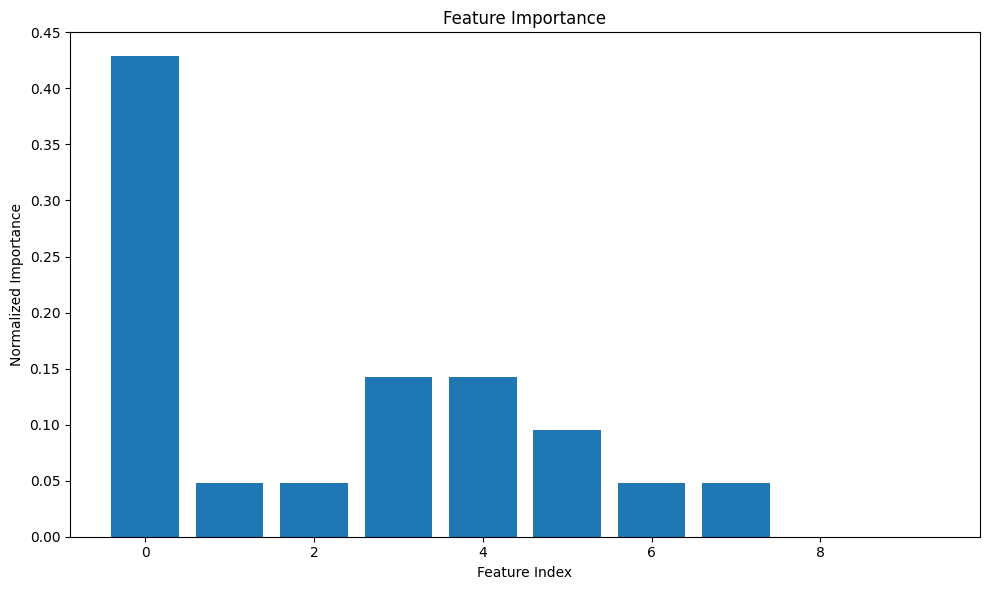

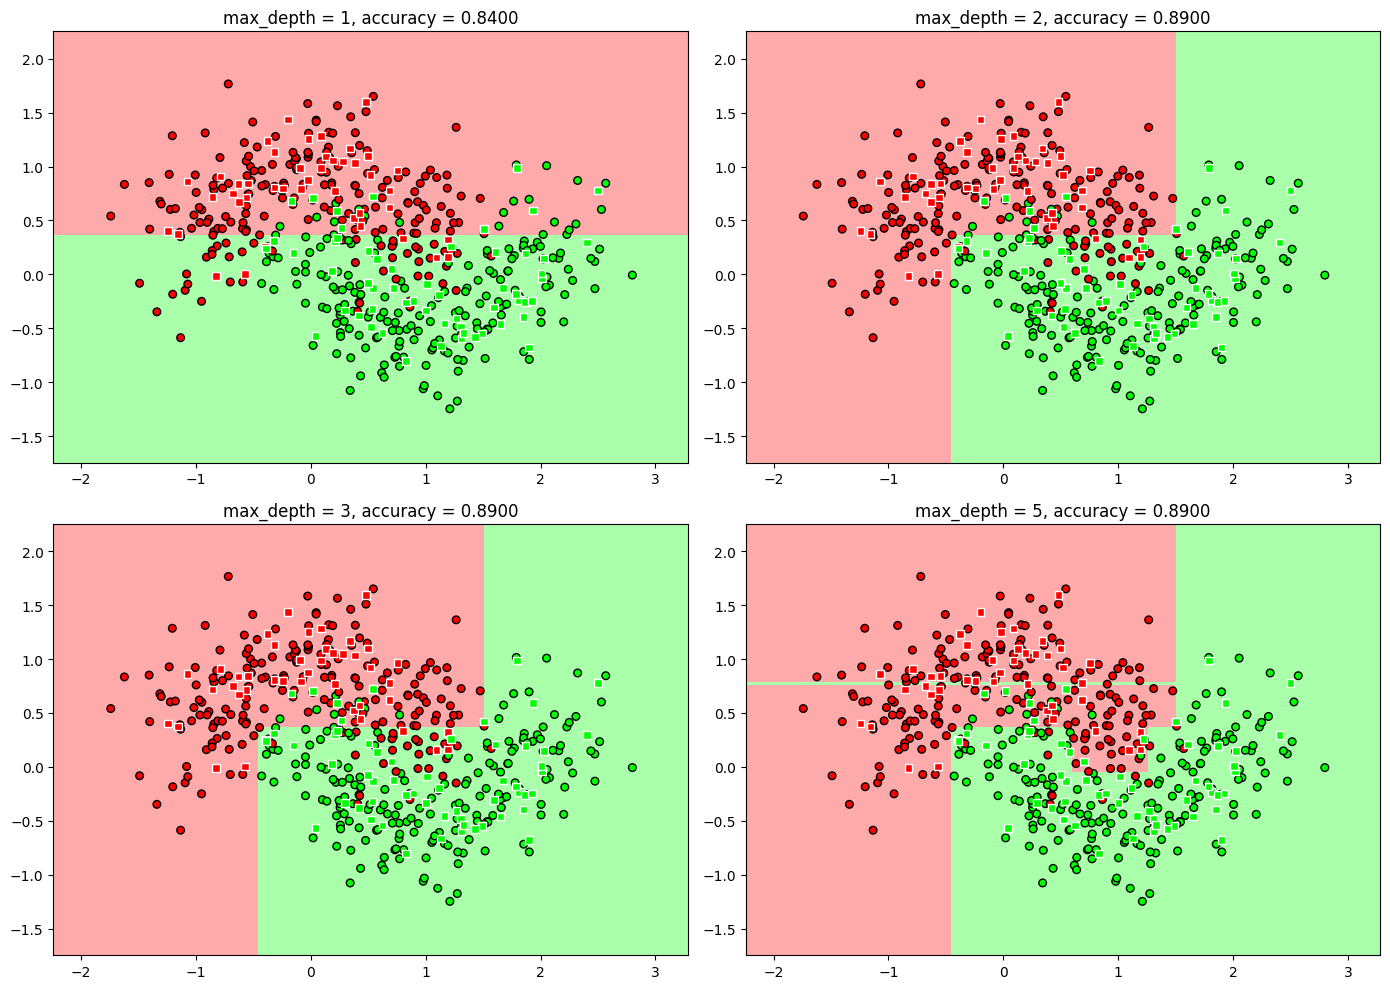

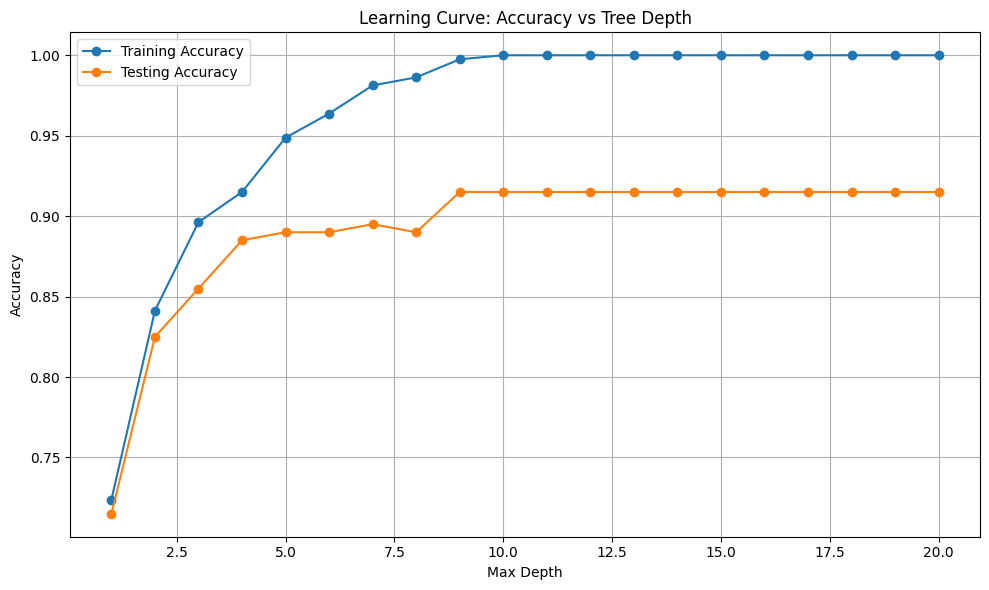

In [5]:
# Example usage with visualizations

if __name__ == "__main__":
    # For visualizations
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    
    # Create a simple dataset
    from sklearn.datasets import make_classification, make_moons
    from sklearn.model_selection import train_test_split
    
    # Example 1: Generate a random classification problem with 10 features
    print("Example 1: Multi-feature classification problem")
    X, y = make_classification(
        n_samples=1000, 
        n_features=10, 
        n_informative=5, 
        n_redundant=2, 
        random_state=42
    )
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Train the decision tree
    tree = DecisionTree(max_depth=5)
    tree.fit(X_train, y_train)
    
    # Make predictions
    y_pred = tree.predict(X_test)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Helper function to visualize tree structure
    def print_tree(node, depth=0):
        indent = "  " * depth
        if node.is_leaf():
            print(f"{indent}Leaf: Class = {node.value}")
        else:
            print(f"{indent}Feature {node.feature} <= {node.threshold}")
            print_tree(node.left, depth + 1)
            print(f"{indent}Feature {node.feature} > {node.threshold}")
            print_tree(node.right, depth + 1)
    
    # Print a portion of the tree structure
    print("\nTree structure (first 3 levels):")
    
    def print_tree_limited(node, depth=0, max_depth=3):
        if depth >= max_depth:
            print("  " * depth + "...")
            return
        indent = "  " * depth
        if node.is_leaf():
            print(f"{indent}Leaf: Class = {node.value}")
        else:
            print(f"{indent}Feature {node.feature} <= {node.threshold}")
            print_tree_limited(node.left, depth + 1, max_depth)
            print(f"{indent}Feature {node.feature} > {node.threshold}")
            print_tree_limited(node.right, depth + 1, max_depth)
    
    print_tree_limited(tree.root)
    
    # Visualize feature importance
    def calculate_feature_importance(tree):
        # Simple feature importance based on how many times a feature is used for splitting
        feature_importance = np.zeros(tree.n_features)
        
        def traverse(node):
            if not node.is_leaf():
                feature_importance[node.feature] += 1
                traverse(node.left)
                traverse(node.right)
        
        traverse(tree.root)
        # Normalize
        if np.sum(feature_importance) > 0:
            feature_importance = feature_importance / np.sum(feature_importance)
        return feature_importance
    
    # Calculate and plot feature importance
    importances = calculate_feature_importance(tree)
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances)
    plt.xlabel('Feature Index')
    plt.ylabel('Normalized Importance')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    print("Feature importance visualization saved as 'feature_importance.png'")
    
    # Example 2: Visualizing decision boundaries with a 2D dataset
    print("\nExample 2: 2D classification with decision boundary visualization")
    
    # Generate a more visual dataset (moons)
    X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train a decision tree with different depths
    depths = [1, 2, 3, 5]
    plt.figure(figsize=(14, 10))
    
    for i, max_depth in enumerate(depths):
        # Train the decision tree
        tree = DecisionTree(max_depth=max_depth)
        tree.fit(X_train, y_train)
        
        # Make predictions and calculate accuracy
        y_pred = tree.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        
        # Plot the decision boundary
        plt.subplot(2, 2, i+1)
        
        # Define the mesh grid
        h = 0.02  # step size in the mesh
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        # Predict on the mesh grid
        Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot the decision boundary
        cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
        cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
        
        plt.contourf(xx, yy, Z, cmap=cmap_light)
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold, s=30, edgecolor='k')
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=30, edgecolor='w', marker='s')
        
        plt.title(f"max_depth = {max_depth}, accuracy = {accuracy:.4f}")
        plt.tight_layout()
    
    plt.savefig('decision_boundaries.png')
    print("Decision boundary visualization saved as 'decision_boundaries.png'")
    
    # Example 3: Learning curve - how accuracy changes with tree depth
    print("\nExample 3: Learning curve visualization")
    
    max_depths = list(range(1, 21))
    train_accuracies = []
    test_accuracies = []
    
    # Generate a more complex dataset
    X, y = make_classification(
        n_samples=1000, 
        n_features=5, 
        n_informative=5, 
        n_redundant=0, 
        n_classes=2, 
        random_state=42
    )
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for depth in max_depths:
        tree = DecisionTree(max_depth=depth)
        tree.fit(X_train, y_train)
        
        # Training accuracy
        y_train_pred = tree.predict(X_train)
        train_acc = np.mean(y_train_pred == y_train)
        train_accuracies.append(train_acc)
        
        # Testing accuracy
        y_test_pred = tree.predict(X_test)
        test_acc = np.mean(y_test_pred == y_test)
        test_accuracies.append(test_acc)
    
    plt.figure(figsize=(10, 6))
    plt.plot(max_depths, train_accuracies, 'o-', label='Training Accuracy')
    plt.plot(max_depths, test_accuracies, 'o-', label='Testing Accuracy')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve: Accuracy vs Tree Depth')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('learning_curve.png')
    print("Learning curve visualization saved as 'learning_curve.png'")

In [5]:
from reportlab.lib.pagesizes import LETTER
from reportlab.pdfgen import canvas
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import Paragraph, SimpleDocTemplate, Spacer, Preformatted, PageBreak
from reportlab.lib.enums import TA_LEFT
from reportlab.lib.units import inch
from reportlab.lib import colors

def create_decision_tree_tutorial():
    try:
        # Set up the PDF
        doc = SimpleDocTemplate("Decision_Tree_Tutorial.pdf", pagesize=LETTER,
                                rightMargin=50, leftMargin=50, topMargin=40, bottomMargin=30)

        # Set up styles - using unique names to avoid conflicts
        styles = getSampleStyleSheet()
        styles.add(ParagraphStyle(name='DT_Heading1', fontSize=18, leading=22, 
                                  spaceAfter=10, spaceBefore=20, textColor=colors.darkblue))
        styles.add(ParagraphStyle(name='DT_Heading2', fontSize=14, leading=18, 
                                  spaceAfter=8, spaceBefore=15, textColor=colors.darkred))
        styles.add(ParagraphStyle(name='DT_Normal', fontSize=11, leading=15))
        styles.add(ParagraphStyle(name='DT_Code', fontName="Courier", fontSize=9, 
                                  leading=11, backColor=colors.whitesmoke, leftIndent=10))
        styles.add(ParagraphStyle(name='DT_Bullet', fontSize=11, leading=15, 
                                  leftIndent=15, bulletIndent=5))

        content = []

        def add_heading(text, level=1):
            style = styles['DT_Heading1'] if level == 1 else styles['DT_Heading2']
            content.append(Paragraph(text, style))
            add_spacer(0.1)

        def add_paragraph(text):
            content.append(Paragraph(text.strip(), styles['DT_Normal']))
            add_spacer(0.1)

        def add_code(code):
            content.append(Preformatted(code.strip(), styles['DT_Code']))
            add_spacer(0.2)

        def add_bullet(text):
            content.append(Paragraph(f"• {text.strip()}", styles['DT_Bullet']))

        def add_spacer(height=0.2):
            content.append(Spacer(1, height * inch))

        # Start building the PDF content
        add_heading("Decision Tree Classifier Tutorial")
        add_paragraph("This tutorial walks through using the Decision Tree Automation package with examples and explanations of the underlying algorithm.")

        add_heading("Table of Contents", level=2)
        toc = [
            "1. Introduction to Decision Trees",
            "2. Quick Start Guide",
            "3. Walkthrough with Example Dataset",
            "4. Understanding the Output",
            "5. Customizing Your Decision Tree",
            "6. Advanced Usage",
            "7. Algorithm Deep Dive"
        ]
        for item in toc:
            add_bullet(item)
        
        add_spacer(0.5)

        # Sections
        add_heading("Introduction to Decision Trees", level=2)
        add_paragraph("Decision trees are supervised learning algorithms used for both classification and regression tasks...")
        
        add_heading("Key Advantages of Decision Trees", level=2)
        advantages = [
            "Interpretability: Easy to understand and visualize",
            "No preprocessing required: Can handle both numerical and categorical data without normalization",
            "Handles non-linear relationships: Can model complex patterns",
            "Feature importance: Naturally provides insight into which features are most important"
        ]
        for adv in advantages:
            add_bullet(adv)

        add_heading("How Decision Trees Work", level=2)
        steps = [
            "Start with all data at the root node",
            "Find the best feature and threshold to split the data",
            "Create child nodes based on the split",
            "Recursively repeat until stopping criteria are met",
            "Predict the majority class in each leaf node"
        ]
        for step in steps:
            add_bullet(step)

        # Add page break before major sections
        content.append(PageBreak())
        
        add_heading("Quick Start Guide", level=2)
        add_paragraph("Installation")
        add_code("pip install numpy pandas matplotlib seaborn scikit-learn")

        add_paragraph("Basic Usage from Command Line:")
        add_code("python decision_tree_automation.py --filepath your_dataset.csv --target target_column_name")

        add_paragraph("Basic Usage from Python Code:")
        add_code("""
from decision_tree_automation import run_decision_tree_analysis

tree, accuracy = run_decision_tree_analysis(
    filepath='your_dataset.csv',
    target_column='target_column_name'
)
""")

        add_heading("Walkthrough with Example Dataset", level=2)
        add_paragraph("Step 1: Prepare your dataset")
        add_code("""
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df.to_csv('iris_dataset.csv', index=False)
""")

        add_paragraph("Step 2: Run the analysis")
        add_code("""
from decision_tree_automation import run_decision_tree_analysis

tree, accuracy = run_decision_tree_analysis(
    filepath='iris_dataset.csv',
    target_column='target',
    max_depth=3,
    criterion='gini'
)
""")

        add_paragraph("Step 3: Review the results\nThe program will print accuracy, classification report, and generate visualizations.")

        add_heading("Understanding the Output", level=2)
        output_parts = [
            "Decision Tree Visualization: Shows decision and leaf nodes with split criteria.",
            "Feature Importance: Highlights most influential features.",
            "Confusion Matrix: Shows performance metrics such as TP, FP, TN, FN."
        ]
        for part in output_parts:
            add_bullet(part)

        add_heading("Customizing Your Decision Tree", level=2)
        add_paragraph("Key Parameters to Adjust:")

        add_paragraph("Maximum Depth (max_depth):")
        add_code("run_decision_tree_analysis(filepath='data.csv', max_depth=4)")

        add_paragraph("Impurity Criterion (criterion):")
        add_code("run_decision_tree_analysis(filepath='data.csv', criterion='entropy')")

        add_paragraph("Test Size (test_size):")
        add_code("run_decision_tree_analysis(filepath='data.csv', test_size=0.25)")

        add_heading("Advanced Usage", level=2)
        add_paragraph("Direct Access to the Classifier:")
        add_code("""
from decision_tree_automation import DecisionTreeClassifier, load_dataset
from sklearn.model_selection import train_test_split

X, y, feature_names = load_dataset('your_dataset.csv', 'target_column_name')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree = DecisionTreeClassifier(max_depth=5, min_samples_split=5, criterion='entropy')
tree.fit(X_train, y_train, feature_names)
predictions = tree.predict(X_test)
tree_structure = tree.tree_structure
""")

        add_paragraph("Custom Visualizations:")
        add_code("""
nodes = tree.tree_structure

for node in nodes:
    if 'value' in node and node['value'] is not None:
        print(f"Leaf node at depth {node['depth']} with path {node['path']}")
        print(f"  Predicts class: {node['value']}")
""")

        add_heading("Algorithm Deep Dive", level=2)
        add_paragraph("Split Selection, Gini Impurity, Entropy, Information Gain")

        add_code("""
Gini(S) = 1 - Σ(p_j²)
Entropy(S) = -Σ(p_j * log2(p_j))
Gain(S, A) = Impurity(S) - Σ((|S_v|/|S|) * Impurity(S_v))
""")

        add_paragraph("Recursive Partitioning and Prediction Process explained.")

        # Build PDF
        doc.build(content)
        print("PDF created successfully: Decision_Tree_Tutorial.pdf")
        
    except Exception as e:
        print(f"Error creating PDF: {str(e)}")

if __name__ == "__main__":
    create_decision_tree_tutorial()

PDF created successfully: Decision_Tree_Tutorial.pdf
